In [23]:
# self-define function
from data_cleaning import cleaning_text_QA, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_QA"

# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string

import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import spacy 
nlp = spacy.load("en_core_web_lg")

from tqdm import tqdm
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Reading the folders and files

In [24]:
# all files path
company_paths = []
sectors = os.listdir(path) 
if '.DS_Store' in sectors:
    sectors.remove('.DS_Store')

for sector in sectors:
    # path to each sector files
    sector_path = path+"/"+sector
    
    # path to each company files
    companies = os.listdir(sector_path)
    if '.DS_Store' in companies:
        companies.remove('.DS_Store')
    
    for company in companies:
        tmp = sector_path+"/"+company
        company_paths.append(tmp)

Concat the text to one dataframe

In [25]:
# ################################## checking with DF (not necessary) ###################################
# company_paticipants_df = pd.DataFrame()
# other_paticipants_df = pd.DataFrame()
# ########################################################################################################

df_clean_na = pd.DataFrame(np.zeros((2500,1)), columns=['index']) # create a dataframe with 2500 rows 
company_paticipants_list = [] 
other_paticipants_list = []
file_without_QA = []

for single_path in company_paths:
    files = os.listdir(single_path)
    for file in files:
        # print(file)
        if file.endswith(".pdf"):
            # print(file)
            # Load PDF
            with open(single_path+"/"+file, "rb") as f:
                pdf = pdftotext.PDF(f)
            # Save all text to a txt file.
            with open(text_save_path+"/"+file.replace(".pdf", ".txt"), "w") as f:
                f.write("\n\n".join(pdf))
            # open the text file
            with open(text_save_path+"/"+file.replace(".pdf", ".txt")) as f:
                content_list = f.readlines()
                # remove the '"' inside the text
                content_list = [re.sub(r'[\n]', '', x) for x in content_list]
                content_list = [re.sub(r'["]', '', x) for x in content_list]
                content_list = [re.sub(r'[\x0c]', '', x) for x in content_list]

                # make each row as a sentence
                contents = pd.DataFrame(content_list)
                # use astype to convert to string
                contents = contents.astype(str)
                contents[0] = contents[0].str.replace('"','')

                df_clean = cleaning_text_QA(contents)  ##### ------> here we use the function from data_cleaning.py
                # check df_clean is all NaN or not
                if df_clean.isna().all().all():
                    print(file+" is without any QA")
                    # continue
                else:
                    tmp_df_text = df_clean.copy()
                    # extract the participants
                    # tmp_df_text,tmp_company_paticipants,tmp_other_paticipants = participants_list(df_clean) ##### ------> here we use the function from participant_function.py
                    # company_paticipants_list.append(tmp_company_paticipants)
                    # other_paticipants_list.append(tmp_other_paticipants)                   

                    index_presentation = tmp_df_text[tmp_df_text[0] == 'Presentation'].index
                    if len(index_presentation) == 2:
                        tmp_df_text.loc[index_presentation[0], 0] = 'heading' # replace the first index_presentation in df_clean with "head" ##### ------> interacting with the participant_function.py

                    # get only the QA part
                    QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == 'Questions And Answers'].tolist()
                    # get the index of the last row of tmp_df_text
                    end_index = [len(tmp_df_text)]
                    if QA_index == []:
                        QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == 'Q&A'].tolist()
                        end_index = [len(tmp_df_text)]
                        # if QA_index == []:
                        #     QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == '(Questions And Answers)'].tolist()
                        #     end_index = [len(tmp_df_text)]
                        #     if QA_index == []:
                        #         QA_index = tmp_df_text.index[tmp_df_text.iloc[:,0] == '(Q&A)'].tolist()
                        #         end_index = [len(tmp_df_text)]
                        if QA_index == []:
                                tmp_df_text = pd.DataFrame(np.zeros((2500,1)))
                                tmp_df_text.iloc[:,0] = np.nan
                                print(file+" is without any QA")
                                # collect the file to file_without_QA list 
                                file_without_QA.append(file)
                        
                    if QA_index != []:
                        tmp_df_text_QA = tmp_df_text.iloc[QA_index[0]+1:end_index[0]]

                    # replace to "" if the row is "(Question And Answer)"
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Question And Answer)',' ')
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Questions And Answers)',' ')
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Q&A)','')
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(Operator Instructions)',' ')
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(inaudible)',' ')
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace('(',' ')
                    tmp_df_text_QA[0] = tmp_df_text_QA[0].str.replace(')',' ')
                    tmp_df_text_QA = tmp_df_text_QA.reset_index(drop=True)

                    # drop the rows with "this is the thing we dont want"
                    # tmp_df_text = tmp_df_text[~tmp_df_text[0].str.contains('')]
                    tmp_df_text = tmp_df_text[tmp_df_text[0] != '']
                    # reset the index
                    tmp_df_text = tmp_df_text.reset_index(drop=True)
                    

                    # ################################## checking with DF (not necessary) ###################################
                    # company_paticipants = pd.DataFrame(company_paticipants)
                    # if company_paticipants.empty:
                    #     company_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                    # company_paticipants_df[f"{files[files.index(file)]}"] = company_paticipants
                    # other_paticipants = pd.DataFrame(other_paticipants)
                    # if other_paticipants.empty:
                    #     other_paticipants = pd.DataFrame(np.zeros((1,1)), columns=['index'])
                    # other_paticipants_df[f"{files[files.index(file)]}"] = other_paticipants
                    # ########################################################################################################
                    
                    df = pd.DataFrame()
                    df[f"{files[files.index(file)]}"] = tmp_df_text_QA
                    # remove the row using re, if the row ends with Presentation  Investor Day	
                    df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)

# drop the first column of the df
df_clean_na = df_clean_na.iloc[:,1:]
# df_clean_na drop the column if that is inside the file_without_QA
for file in file_without_QA:
    df_clean_na.drop(columns=file,inplace=True)

df_clean_na.head(20)

/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:228: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('*','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:229: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace('[','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:230: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[0] = df[0].str.replace(']','')
/Users/timliu/Documents/GitHub/BoE_ARP/data_cleaning.py:235: FutureWarning: The default value of regex 

20190307_Sanlam_Ltd-_Earnings_Call_2019-3-7_RT000000002597264782.pdf is without any QA
20191204_Sanlam_Ltd-_Sales_Results_Call_2019-12-4_RT000000002759752564.pdf is without any QA
20190815_Aegon_NV-_Earnings_Call_2019-8-15_SD000000002900996987.pdf is without any QA
20191212_Aegon_NV-_Shareholder_Mtg_Call_2019-12-12_RT000000002764125321.pdf is without any QA
20180816_Aegon_NV-_Earnings_Call_2018-8-16_SD000000002900996247.pdf is without any QA
20190214_Aegon_NV-_Earnings_Call_2019-2-14_SD000000002900996777.pdf is without any QA


/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/1336931732.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_clean_na[f"{files[files.index(file)]}"] = df[f"{files[files.index(file)]}"].dropna(inplace=False).reset_index(drop=True)


20170918_Discovery_Ltd-_Earnings_Call_2017-9-18_FS000000002373098887.pdf is without any QA
20190904_Discovery_Ltd-_Earnings_Call_2019-9-4_SD000000002908028677.pdf is without any QA
20180904_Discovery_Ltd-_Earnings_Call_2018-9-4_FS000000002466202535.pdf is without any QA
20160906_Discovery_Ltd-_Earnings_Call_2016-9-6_DN000000002303208391.pdf is without any QA
20190905_Discovery_Ltd-_Earnings_Call_2019-9-5_DN000000002706000872.pdf is without any QA
20180220_Discovery_Ltd-_Earnings_Call_2018-2-20_FS000000002401121504.pdf is without any QA
20190221_Discovery_Ltd-_Earnings_Call_2019-2-21_FS000000002590545764.pdf is without any QA
20210602_Prudential_PLC-_Shareholder_Mtg_Call_2021-6-2_SD000000002958332720.pdf is without any QA
20160317_LEGAL_-_GEN_GRP-_Conf-Presentation_Call_2016-3-17_FS000000002261248537.pdf is without any QA
20181115_LEGAL_-_GEN_GRP-_Shareholder_Mtg_Call_2018-11-15_SD000000002905609384.pdf is without any QA
20131218_Sompo_Holdings_Inc-_M-A_Call_2013-12-18_SD000000002864021

,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,20200811_Quilter_PLC-_Earnings_Call_2020-8-11_DN000000002883967732.pdf,20190805_Quilter_PLC-_Earnings_Call_2019-8-5_RT000000002897819838.pdf,20180808_Quilter_PLC-_Earnings_Call_2018-8-8_FS000000002459369907.pdf,20210401_Quilter_PLC-_M-A_Call_2021-4-1_RT000000002954187686.pdf,20171219_Quilter_PLC-_M-A_Call_2017-12-19_SD000000002919419964.pdf,20210310_Quilter_PLC-_Earnings_Call_2021-3-10_RT000000002952420637.pdf,20140904_Sanlam_Ltd-_Earnings_Call_2014-9-4_DN000000002170588806.pdf,...,20140424_Everest_Re_Group_Ltd-_Earnings_Call_2014-4-24_SD000000002701577115.pdf,20211028_Everest_Re_Group_Ltd-_Earnings_Call_2021-10-28_DN000000002966766153.pdf,20170207_Everest_Re_Group_Ltd-_Earnings_Call_2017-2-7_FS000000002327179820.pdf,20160204_Everest_Re_Group_Ltd-_Earnings_Call_2016-2-4_FS000000002251252548.pdf,20140724_Everest_Re_Group_Ltd-_Earnings_Call_2014-7-24_FS000000002439093631.pdf,20171031_Everest_Re_Group_Ltd-_Earnings_Call_2017-10-31_DN000000002379633496.pdf,20150428_Everest_Re_Group_Ltd-_Earnings_Call_2015-4-28_FS000000002207058997.pdf,20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf
0,Paul Feeney,Operator,Andrew Sinclair,Operator,Operator,Andrew Sinclair,Operator,Operator,Operator,Unidentified Participant,...,Operator,Operator,Operator,Operator,Operator,Operator,Operator,Operator,Operator,Operator
1,17570862,,17749036,Our first question comes from the line of Andr...,,17749036,,And our first question comes from Andy Sin...,,.,...,Thank you. The question and answer session wil...,And your first question is from Elyse Gree...,Certainly. And we will go first to Elyse Green...,Thank you. Thank you. Our first question comes...,Thank you. And we'll go first to Amit Kumar wi...,. And we will go first to Elyse Greenspan w...,We'll take our first question from Kai Pan wit...,,,"Amit Kumar, Macquarie Capital."
2,,Thank you. Our first question comes from t...,Thanks. It's Andy Sinclair from Bank of Americ...,ahead.,Andrew Sinclair,Thanks. It's Andy Sinclair from BoFA Merrill L...,Thank you. Our first question comes from t...,America Merrill Lynch.,Thank you. Let's go with our first questio...,Johan van Zyl,...,Instructions Our first question will come from...,Elyse Greenspan,Elyse B. Greenspan,your line is open.,Amit Kumar,Elyse Greenspan,Kai Pan,"Amit Kumar, Macquarie.",Gregory Locraft with Morgan Stanley.,Amit Kumar
3,Andrew Sinclair,Sinclair of Bank of America. Please go ahead. ...,"please. Firstly, really good to see the platfo...",Andrew Sinclair,17749036,number of Restricted Financial Planners. That'...,from Bank of America. Please go ahead.,Andrew Sinclair,of America. Your line is now open. Please go a...,4080290,...,Jay Gelb,17263315,17263315,Vinay Misquith,16979665,17263315,18669701,Amit Kumar,Gregory Locraf t,15025799
4,17749036,Andrew Sinclair,"on a bit of bizarre market, but I just wondere...",21847791,Thanks. This is Andrew Sinclair Bank of the Me...,wondering if you can give us thoughts on H2 gr...,Andrew Sinclair,17749036,Andrew Sinclair,"Well, of course, we have to talk about the ...",...,21247396,Hi. Thanks. Good morning. My first question is...,"Hi. Good morning. First off, if you could just...",6989856,Thanks and good morning. Just two quick questi...,"Hi, good morning. My first question, just on g...",Good morning. Thank you. And first question is...,15025799,16836287,Thanks and good morning. I guess two or three ...
5,Thanks. It's Andrew Sinclair from BofA Merrill...,17749036,flows are differring for advisers who have mig...,"Thanks, and good morning, everyone. Three from...","okay. Firstly on Lighthouse, Inaudible not s..

In [26]:
len(file_without_QA)

159

Clean the participants list and get all, company, and other participants list

In [27]:
# generating all the participants
company_paticipants_list = clean_participants_list(company_paticipants_list)
other_paticipants_list = clean_participants_list(other_paticipants_list)
all_participants_list_tmp = []
all_participants_list_tmp = company_paticipants_list + other_paticipants_list

# drop the duplicates
all_participants_list = []
for x in all_participants_list_tmp:
    if x not in all_participants_list:
        all_participants_list.append(x)


Add two columns which include participants and the index of the participant (to be used for merging as paragraph)

In [28]:
concat_df = pd.DataFrame()
participants_index =pd.DataFrame(np.zeros((2500,1)), columns=['index'])
for column in df_clean_na.columns:
    # identify all the rows in df with all_participants_list in it
    both_participants_row_index = df_clean_na[df_clean_na[column].isin(all_participants_list)].index.tolist()
    # apply the both_participants_row_index to the df_clean_na['participants']
    concat_df[column] = df_clean_na[column]
    ppt_list = df_clean_na[column].apply(lambda x: x if x in all_participants_list else 0)
    idx_list = [int(idx) if ppt_list[idx] != 0 else np.nan for idx in range(len(ppt_list)) ]
    # adding paricipants name
    concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
    # adding index columns
    concat_df[f"idx_{column}"] = idx_list
    # fill the NaN with the value of the previous row
    concat_df[f"participants_{column}"] = concat_df[f"participants_{column}"].fillna(method='ffill')
    concat_df[f"idx_{column}"] = concat_df[f"idx_{column}"].fillna(method='ffill')

concat_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/3263364826.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"participants_{column}"] = [name if name != 0 else np.nan for name in ppt_list]
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/3263364826.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[f"idx_{column}"] = idx_list
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/3263364826.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is us

,20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,participants_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,idx_20190312_Quilter_PLC-_Earnings_Call_2019-3-12_RT000000002903022737.pdf,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,participants_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,idx_20210811_Quilter_PLC-_Earnings_Call_2021-8-11_RT000000002962310912.pdf,20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,participants_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,idx_20200311_Quilter_PLC-_Earnings_Call_2020-3-11_DN000000002822346246.pdf,20200811_Quilter_PLC-_Earnings_Call_2020-8-11_DN000000002883967732.pdf,...,idx_20150428_Everest_Re_Group_Ltd-_Earnings_Call_2015-4-28_FS000000002207058997.pdf,20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,participants_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,idx_20120726_Everest_Re_Group_Ltd-_Earnings_Call_2012-7-26_SD000000002701554249.pdf,20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,participants_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,idx_20121025_Everest_Re_Group_Ltd-_Earnings_Call_2012-10-25_SD000000002719409327.pdf,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,participants_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf,idx_20130724_Everest_Re_Group_Ltd-_Earnings_Call_2013-7-24_SD000000002719418375.pdf
0,Paul Feeney,NaN,NaN,Operator,Operator,0.0,Andrew Sinclair,NaN,NaN,Operator,...,0.0,Operator,Operator,0.0,Operator,Operator,0.0,Operator,Operator,0.0
1,17570862,NaN,NaN,,Operator,0.0,17749036,NaN,NaN,Our first question comes from the line of Andr...,...,0.0,,Operator,0.0,,Operator,0.0,"Amit Kumar, Macquarie Capital.",Operator,0.0
2,,NaN,NaN,Thank you. Our first question comes from t...,Operator,0.0,Thanks. It's Andy Sinclair from Bank of Americ...,NaN,NaN,ahead.,...,0.0,"Amit Kumar, Macquarie.",Operator,0.0,Gregory Locraft with Morgan Stanley.,Operator,0.0,Amit Kumar,Operator,0.0
3,Andrew Sinclair,NaN,NaN,Sinclair of Bank of America. Please go ahead. ...,Operator,0.0,"please. Firstly, really good to see the platfo...",NaN,NaN,Andrew Sinclair,...,0.0,Amit Kumar,Operator,0.0,Gregory Locraf t,Operator,0.0,15025799,Operator,0.0
4,17749036,NaN,NaN,Andrew Sinclair,Operator,0.0,"on a bit of bizarre market, but I just wondere...",NaN,NaN,21847791,...,0.0,15025799,Operator,0.0,16836287,Operator,0.0,Thanks and good morning. I guess two or three ...,Operator,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,NaN,NaN,NaN,NaN,Operator,407.0,NaN,NaN,NaN,NaN,...,568.0,NaN,Operator,414.0,NaN,Operator,497.0,NaN,Operator,419.0
2496,NaN,NaN,NaN,NaN,Operator,407.0,NaN,NaN,NaN,NaN,...,568.0,NaN,Operator,414.0,NaN,Operator,497.0,NaN,Operator,419.0
2497,NaN,NaN,NaN,NaN,Operator,407.0,NaN,NaN,NaN,NaN,...,568.0,NaN,Operator,414.0,NaN,Operator,497.0,NaN,Operator,419.0
2498,NaN,NaN,NaN,NaN,Operator,407.0,NaN,NaN,NaN,NaN,...,568.0,NaN,Operator,414.0,NaN,Operator,497.0,NaN,Operator,419.0


make the dataframe as horizontal instead of vertical, and get the company_paticipants_yes and other_paticipants_yes

In [29]:
model_df = pd.DataFrame()
for i in range(int(len(concat_df.columns.to_list())/3)):
    #print(i)
    tmp_df = pd.DataFrame()
    tmp_df = concat_df.iloc[:,(i*3):(i*3)+3].copy()
    # extract the index as column from the text
    tmp_df['file_name'] = tmp_df.columns.to_list()[0]
    # extract the date from the index column
    tmp_df['date'] = tmp_df['file_name'].apply(lambda x: x.split('_')[0])
    # change the date column to datetime
    tmp_df['date'] = pd.to_datetime(tmp_df['date'])
    # rename to be consistent with the column name
    tmp_df.columns = ["line", "participants",  "idx", "file_name","date"]
    # if the 'participants' column's value equals to any of the company_paticipants_list, other_paticipants_list, then set the value to 0
    tmp_df['company_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in company_paticipants_list else 0)
    tmp_df['other_paticipants_yes'] = tmp_df['participants'].apply(lambda x: 1 if x in other_paticipants_list else 0)
    # drop the row if the column "line" is NaN
    tmp_df = tmp_df.dropna(subset=['line'], how='all')
    tmp_df['company_name1']  = tmp_df['file_name'].apply(lambda x: x.split('_')[1])
    tmp_df['company_name2']  = tmp_df['file_name'].apply(lambda x: x.split('_')[2])
    tmp_df['company_name'] = tmp_df["company_name1"] + " " + tmp_df["company_name2"]
    # drop the 'company_name1' and 'company_name2' column
    tmp_df = tmp_df.drop(columns=['company_name1', 'company_name2']).reset_index(drop=True)
    # drop line contains only participants name
    id_rows = tmp_df[tmp_df['line']==tmp_df['participants']].index
    tmp_df = tmp_df.drop(id_rows)
    # append into dataframe
    model_df = model_df.append(tmp_df)

# drop the Nan rows (no participants and idx, which are not what we want)
model_df = model_df.dropna(subset=['participants','idx'], how='all')
model_df

,line,participants,idx,file_name,date,company_paticipants_yes,other_paticipants_yes,company_name
1,,Operator,0.0,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_...,2021-08-11,1,1,Quilter PLC-
2,Thank you. Our first question comes from t...,Operator,0.0,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_...,2021-08-11,1,1,Quilter PLC-
3,Sinclair of Bank of America. Please go ahead. ...,Operator,0.0,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_...,2021-08-11,1,1,Quilter PLC-
4,Andrew Sinclair,Operator,0.0,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_...,2021-08-11,1,1,Quilter PLC-
5,17749036,Operator,0.0,20210811_Quilter_PLC-_Earnings_Call_2021-8-11_...,2021-08-11,1,1,Quilter PLC-
...,...,...,...,...,...,...,...,...
415,back over to management for any closing or add...,Operator,413.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
416,Beth Farrell,Operator,413.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
417,19732216,Operator,413.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re
418,I would just like to thank everybody for joini...,Operator,413.0,20130724_Everest_Re_Group_Ltd-_Earnings_Call_2...,2013-07-24,1,1,Everest Re


Use the idx to merge the participants and the text, the model_df will represent with paragraph and the other details

In [30]:
# model_df groupby 'participants','file_name','date','company_paticipants_yes','other_paticipants_yes','company_name' with ['sentence'] and .apply(' '.join)
model_df = model_df.groupby(['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name'])['line'].apply(' '.join).reset_index()
# model_df rename the column 'sentence' to 'paraghrph'
model_df.columns = ['participants','file_name','date', 'idx', 'company_paticipants_yes','other_paticipants_yes','company_name','paraghrph']
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205..."
1,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi..."
2,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,162.0,1,1,Mapfre SA,"Federico Salerno, MainFirst. Federico Salerno ..."
3,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,198.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous. Giulia Raffo 757385..."
4,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,361.0,1,1,Mapfre SA,"Francisco Riquel, N+1. Francisco Riquel 30503..."
...,...,...,...,...,...,...,...,...
14203,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...
14204,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,383.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Alexander ...
14205,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,442.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Faizan Lak...
14206,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,489.0,1,1,GJENSIDIGE FORSI-,We'll take our next question from Jan Erik fro...


# Remove the participants and post_clean

In [31]:
def clean_tokens(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # # step 2: change the list to lower case
    # text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

Remove the name in the text

In [32]:
def participants_tokens(all_participants_list):
    # all_participants_list list to dataframe
    tmp_df = pd.DataFrame(all_participants_list)
    # test replace the dot with ""
    tmp_df[0] = tmp_df[0].str.replace('.','')
    # apply the clean_tokens function to the tmp_df dataframe
    tmp_participants_tokens = clean_tokens(tmp_df[0])
    # append all the tokens to list
    participants_tokens = []
    for i in tmp_participants_tokens:
        participants_tokens.extend(i)
    return participants_tokens

participants_tokens = participants_tokens(all_participants_list)
# participants_tokens remove the vlaue that the len is less than 3
participants_tokens = [i for i in participants_tokens if len(i)>2]
# participants_tokens

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/3219497472.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tmp_df[0] = tmp_df[0].str.replace('.','')
100%|██████████| 1/1 [00:00<00:00, 18.69it/s]


In [33]:
# # lowercase the all_participants_list, for the purpose of removing in the model_df (which is not important for the model)
# all_participants_list_lc = [i.lower() for i in all_participants_list]

In [34]:
def post_process(df):
    # create a new column 'paraghrph_clean'
    df['paraghrph_clean'] = df['paraghrph']
    # remove the participants name from 'paraghrph' if exist in participants_tokens
    for i in participants_tokens:
        df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(i,'')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(',','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace(')','')
    df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(through translator)','')

    return df

model_df = post_process(model_df)

pd.set_option('display.max_columns', None)
print(model_df['file_name'].nunique())
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/4063045589.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('.','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/4063045589.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['paraghrph_clean'] = df['paraghrph_clean'].str.replace('(','')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/4063045589.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['parag

1447


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin 3878205 ...
1,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi...",Marcus Rivaldi Morgan Stanley Marcus Rivaldi ...
2,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,162.0,1,1,Mapfre SA,"Federico Salerno, MainFirst. Federico Salerno ...",Federico Salerno MainFirst Federico Salerno 2...
3,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,198.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous. Giulia Raffo 757385...",Giulia Raffo Autonomous Giulia Raffo 7573856 ...
4,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,361.0,1,1,Mapfre SA,"Francisco Riquel, N+1. Francisco Riquel 30503...",Francisco Riquel N+1 Francisco Riquel 3050316...
...,...,...,...,...,...,...,...,...,...
14203,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...
14204,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,383.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Alexander ...,We will take our next question from Alexander ...
14205,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,442.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Faizan Lak...,We will take our next question from Faizan Lak...
14206,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,489.0,1,1,GJENSIDIGE FORSI-,We'll take our next question from Jan Erik fro...,We'll take our next question from Jan Erik fro...


Remove the numeric values

In [35]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')
model_df['paraghrph_clean']= model_df['paraghrph_clean'].astype(str)

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/2780780902.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_clean'] = model_df['paraghrph_clean'].str.replace('\d+', '')


In [36]:
nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
# nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
def lemmatization(texts, allowed_postags=["NOUN"]):
    doc = nlp(texts)
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags:
            new_text.append(token.lemma_)
    final = " ".join(new_text)
    return (final) # 

# use apply the lemmatization function to the tmp_df dataframe
model_df['paraghrph_noun'] = model_df['paraghrph_clean'].apply(lemmatization)

model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...
1,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi...",Marcus Rivaldi Morgan Stanley Marcus Rivaldi ...,afternoon gentleman couple question asset mix ...
2,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,162.0,1,1,Mapfre SA,"Federico Salerno, MainFirst. Federico Salerno ...",Federico Salerno MainFirst Federico Salerno ...,evening look property line year week year slid...


# Tokenizing the text

Apply the function to paraghrph_noun and get the token 

In [76]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [77]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/458752224.py:2: DeprecationWarning: invalid escape sequence \d
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_11906/458752224.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
100%|██████████| 13276/13276 [01:52<00:00, 118.09it/s]


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[number, question, sense, release, contributio...",191,1335,92,6.989529,2.076087
17,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,604.0,1,1,Mapfre SA,And at this time there are no further question...,And at this time there are no further question...,time question conference call result presentation,"[time, question, conference, result, presentat...",5,40,6,8.000000,0.833333
16,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi...",Marcus Rivaldi Morgan Stanley Marcus Rivaldi ...,afternoon gentleman couple question asset mix ...,"[afternoon, gentleman, couple, question, asset...",35,243,21,6.942857,1.666667
15,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,162.0,1,1,Mapfre SA,"Federico Salerno, MainFirst. Federico Salerno ...",Federico Salerno MainFirst Federico Salerno ...,evening look property line year week year slid...,"[evening, property, year, week, year, slide, c...",48,337,25,7.020833,1.920000
14,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,198.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous. Giulia Raffo 757385...",Giulia Raffo Autonomous Giulia Raffo I have...,question clarification investment income disto...,"[question, clarification, investment, income, ...",203,1304,92,6.423645,2.206522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13270,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,219.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Hakon Astr...,We will take our next question from Hakon Astr...,question market line morning question question...,"[question, market, morning, question, question...",109,720,31,6.605505,3.516129
13271,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,275.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Jan Erik f...,We will take our next question from Jan Erik f...,question line question inﬂation question bit d...,"[question, question, inﬂation, question, bit, ...",82,563,40,6.865854,2.050000
13272,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...,question line morning question claim claim eﬀe...,"[question, morning, question, claim, claim, eﬀ...",77,493,20,6.402597,3.850000
13273,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,383.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Alexander ...,We will take our next question from Alexander ...,question line thank question thank plan conﬁde...,"[question, question, plan, conﬁdence, level, r...",120,762,38,6.350000,3.157895


# Word-Length Count

In [78]:
# create column for length analysis outcome
model_df['word_count'] = model_df["token"].apply(lambda x: len(x))
model_df['char_count'] = model_df["token"].apply(lambda x: sum(len(word) for word in x))
model_df['sentence_count']  = model_df['paraghrph'].apply(lambda x: len(str(x).split(".")))
model_df['avg_word_length'] = model_df['char_count'] / model_df['word_count']
model_df['avg_sentence_length'] = model_df['word_count'] / model_df['sentence_count'] # note that the word_count is only with noun tokens
model_df.head(3)

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[number, question, sense, release, contributio...",191,1335,92,6.989529,2.076087
17,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,604.0,1,1,Mapfre SA,And at this time there are no further question...,And at this time there are no further question...,time question conference call result presentation,"[time, question, conference, result, presentat...",5,40,6,8.000000,0.833333
16,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi...",Marcus Rivaldi Morgan Stanley Marcus Rivaldi ...,afternoon gentleman couple question asset mix ...,"[afternoon, gentleman, couple, question, asset...",35,243,21,6.942857,1.666667


Exclude the rows that the sentence_count is less than 3 (not important to our tp modelling)

In [79]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

# Drop the duplicates

In [80]:
len(model_df)
check_dup = model_df.copy()
check_dup['true_false'] = model_df.duplicated(subset=['paraghrph'])
print(check_dup['true_false'].value_counts())
# leave only one row for each paraghrph
model_df = model_df.drop_duplicates(subset=['paraghrph'])
model_df = model_df.reset_index(drop=True)
print(len(model_df))

False    13276
Name: true_false, dtype: int64
13276


# Load the df so the above we don't have to rerun anagin

In [81]:
# save the dataframe to csv file
model_df.to_csv('./main_df_output/topic_modelling_QA_df.csv', index=False) # careful the file is not saving tokenized data
# # call out the model_df CSV
# model_df = pd.read_csv('./main_df_output/topic_modelling_QA_df.csv')
# # model_df sort by date
# model_df = model_df.sort_values(by=['date'])
# pd.set_option('display.max_columns', None)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[number, question, sense, release, contributio...",191,1335,92,6.989529,2.076087
1,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,604.0,1,1,Mapfre SA,And at this time there are no further question...,And at this time there are no further question...,time question conference call result presentation,"[time, question, conference, result, presentat...",5,40,6,8.000000,0.833333
2,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi...",Marcus Rivaldi Morgan Stanley Marcus Rivaldi ...,afternoon gentleman couple question asset mix ...,"[afternoon, gentleman, couple, question, asset...",35,243,21,6.942857,1.666667
3,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,162.0,1,1,Mapfre SA,"Federico Salerno, MainFirst. Federico Salerno ...",Federico Salerno MainFirst Federico Salerno ...,evening look property line year week year slid...,"[evening, property, year, week, year, slide, c...",48,337,25,7.020833,1.920000
4,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,198.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous. Giulia Raffo 757385...",Giulia Raffo Autonomous Giulia Raffo I have...,question clarification investment income disto...,"[question, clarification, investment, income, ...",203,1304,92,6.423645,2.206522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,219.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Hakon Astr...,We will take our next question from Hakon Astr...,question market line morning question question...,"[question, market, morning, question, question...",109,720,31,6.605505,3.516129
13272,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,275.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Jan Erik f...,We will take our next question from Jan Erik f...,question line question inﬂation question bit d...,"[question, question, inﬂation, question, bit, ...",82,563,40,6.865854,2.050000
13273,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,341.0,1,1,GJENSIDIGE FORSI-,Our next question comes from Thomas Svendsen f...,Our next question comes from Thomas Svendsen f...,question line morning question claim claim eﬀe...,"[question, morning, question, claim, claim, eﬀ...",77,493,20,6.402597,3.850000
13274,Operator,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,383.0,1,1,GJENSIDIGE FORSI-,We will take our next question from Alexander ...,We will take our next question from Alexander ...,question line thank question thank plan conﬁde...,"[question, question, plan, conﬁdence, level, r...",120,762,38,6.350000,3.157895


In [82]:
# # visualize the distribution of the dataset
# x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "company_paticipants_yes"
# fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
# for i in model_df[y].unique():
#     sns.distplot(model_df[model_df[y]==i][x1], hist=True, kde=False, 
#                  bins=10, hist_kws={"alpha":0.8}, 
#                  axlabel="histogram", ax=ax[0])
#     sns.distplot(model_df[model_df[y]==i][x2], hist=True, kde=False, 
#                  bins=10, hist_kws={"alpha":0.8}, 
#                  axlabel="histogram", ax=ax[1])
#     sns.distplot(model_df[model_df[y]==i][x3], hist=True, kde=False, 
#                  bins=10, hist_kws={"alpha":0.8}, 
#                  axlabel="histogram", ax=ax[2])
#     sns.distplot(model_df[model_df[y]==i][x4], hist=True, kde=False, 
#                  bins=10, hist_kws={"alpha":0.8}, 
#                  axlabel="histogram", ax=ax[3])
#     sns.distplot(model_df[model_df[y]==i][x5], hist=True, kde=False, 
#                  bins=10, hist_kws={"alpha":0.8}, 
#                  axlabel="histogram", ax=ax[4])
# ax[0].grid(True)
# ax[0].legend(model_df[y].unique())
# ax[0].set_title("word_count")
# ax[1].grid(True)
# ax[1].legend(model_df[y].unique())
# ax[1].set_title("char_count")
# ax[2].grid(True)
# ax[2].legend(model_df[y].unique())
# ax[2].set_title("avg_word_length")
# ax[3].grid(True)
# ax[3].legend(model_df[y].unique())
# ax[3].set_title("sentence_count")
# ax[4].grid(True)
# ax[4].legend(model_df[y].unique())
# ax[4].set_title("avg_sentence_lenghth")
# plt.show()

high frequency words excluding

In [97]:
# drop the afternoon, morning, conference, today,lady, gentleman
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if i not in [
    'afternoon', 'morning', 'conference','today','lady', 'gentleman', 'presentation',
    'question','answer', 'slide',
    'proÔ¨Åt', 'eÔ¨Äect','proÔ¨Åtability','oÔ¨Ä','diÔ¨Äerent','eÔ¨Éciency','Ô¨Ågure','inÔ¨Çation','Ô¨Çow','conÔ¨Åt',
    'mm', 'mm_mm','guy','sir',' ','host_sir','bb','ty','word', 'year', 'quer','month','period', 'day', 'time','result', 'investor','week', 'update',
    'Ô¨Åre','diÔ¨Äerence','diÔ¨Écult','beneÔ¨Åt', 'business','lot','ratio','rate','quarter', 'number', 'point', 'term', 'thing', 'level', 
    'bit', 'sort', 'reason', 'management', 'fact', 'case', 'area', 'people', 'sense', 'item', 'issue', 'market'
     ]])
model_df.head()

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,1,Mapfre SA,"James Quin, Citigroup. James Quin 3878205...",James Quin Citigroup James Quin Three n...,number question one call sense release contrib...,"[contribution, debate, phase, nonlife, triangl...",191,1335,92,6.989529,2.076087
1,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,604.0,1,1,Mapfre SA,And at this time there are no further question...,And at this time there are no further question...,time question conference call result presentation,[],5,40,6,8.000000,0.833333
2,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,134.0,1,1,Mapfre SA,"Marcus Rivaldi, Morgan Stanley. Marcus Rivaldi...",Marcus Rivaldi Morgan Stanley Marcus Rivaldi ...,afternoon gentleman couple question asset mix ...,"[institution, breakdown, classification, cover...",35,243,21,6.942857,1.666667
3,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,162.0,1,1,Mapfre SA,"Federico Salerno, MainFirst. Federico Salerno ...",Federico Salerno MainFirst Federico Salerno ...,evening look property line year week year slid...,"[evening, component, car, impression, tariff, ...",48,337,25,7.020833,1.920000
4,Operator,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,198.0,1,1,Mapfre SA,"Giulia Raffo, Autonomous. Giulia Raffo 757385...",Giulia Raffo Autonomous Giulia Raffo I have...,question clarification investment income disto...,"[clarification, distortion, inmuebles, rent, t...",203,1304,92,6.423645,2.206522


In [98]:
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)

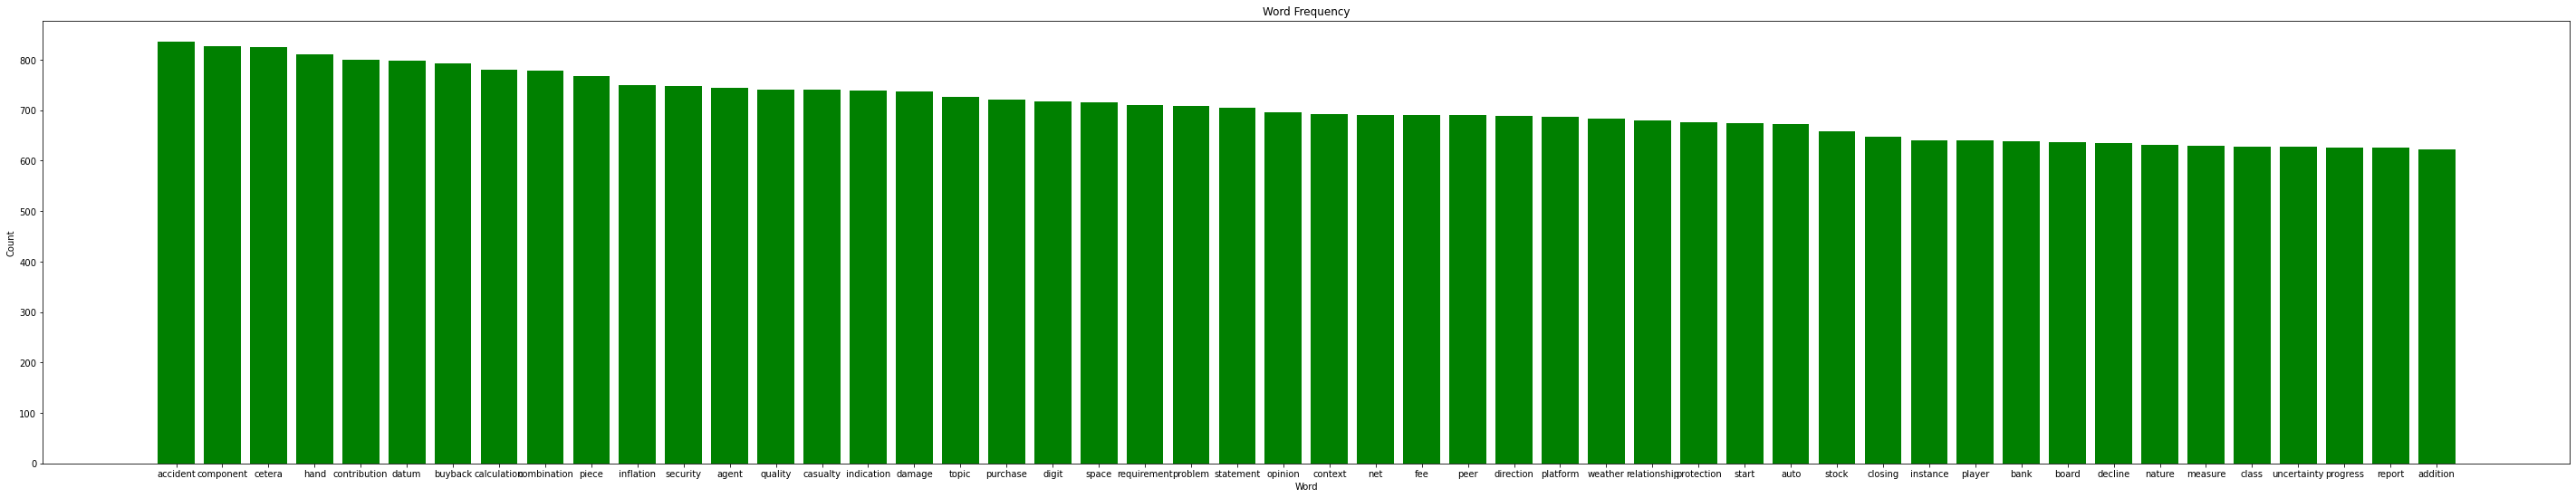

,word,freq
0,accident,836
1,component,827
2,cetera,825
3,hand,811
4,contribution,800
5,datum,798
6,buyback,793
7,calculation,781
8,combination,779
9,piece,767


In [99]:
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(50, 9))
plt.bar(word_fr.word[0:50], word_fr.freq[0:50], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()
word_fr.head(50)

In [100]:
# # remove 150 most frequent words which is known in this context
# word_list = word_fr.head(150)['word'].to_list()
# mdy_list, tmp=[],[]
# for review in docs_tokens:
#     for word in review:
#         if word not in word_list:
#             tmp.append(word)
#     mdy_list.append(tmp)
#     tmp=[]

# model_df['token'] = mdy_list

# recrate again for getting the docs_tokens
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)

In [101]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram = Phrases(                              
    docs_tokens,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram = Phrases(                             
    bigram[docs_tokens],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]
# docs_phrased

In [102]:
len(docs_phrased)

13276

In [95]:
# With Tomotopy, it is necessary to wrap the preprocessed documents in a corpus-like object
# create corpus
corpus = tp.utils.Corpus()                   
for item in docs_phrased:                   
    if item != []:
        corpus.add_doc(words=item)
    else:
        corpus.add_doc(words=" ")
print(len(corpus))

13276


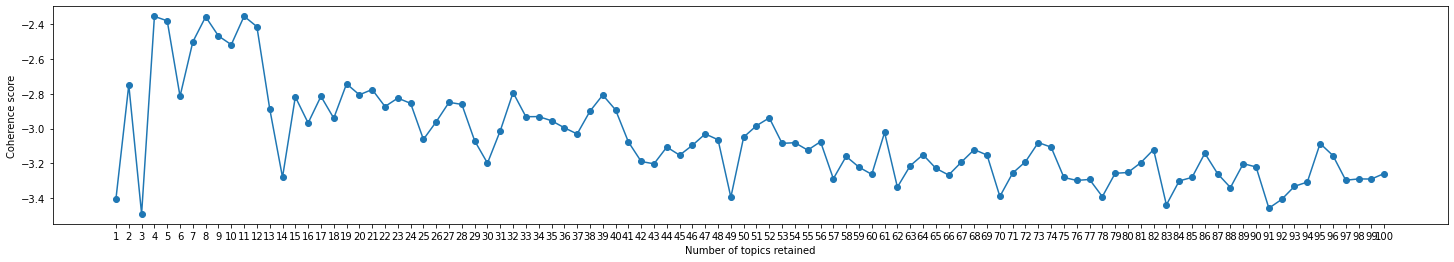

In [103]:
# Explore the fit of surrogate models, i.e. models that retain different numbers of topics.
cvs = {}                                    # step 1 We create an empty dictionary to store the scores of different models.
for topic_number in range(1, 101, 1):        # step 2 We let the number of retained topics vary between models, and for each model we record the associated Coherence Score
    mdl = tp.LDAModel(k=topic_number, corpus=corpus, seed = 1) # our over all words
    for i in range(0, 100, 10): # 100 iterations
        mdl.train(10)
        # print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    cvs[topic_number] = coh.get_score() # lower is better

# plot the Coherence Score
fig = plt.figure(figsize=(25, 4))
ax = fig.add_subplot(111)
ax.plot(cvs.keys(), cvs.values(), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 101, 1))
plt.show()

# With 3 topics

In [107]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=3, corpus=corpus, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,casualty,0.010,0,0
1,platform,0.009,0,1
2,accident,0.007,0,2
3,commission,0.007,0,3
4,space,0.006,0,4
5,inflation,0.006,0,5
6,catastrophe,0.006,0,6
7,class,0.006,0,7
8,protection,0.005,0,8
9,datum,0.005,0,9


In [108]:
import pyLDAvis
# Creating a function to prepare the data for visualisation
def topic_plot_data(best_mdl):
    topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
    doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
    doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs]) 
    vocab = list(best_mdl.used_vocabs)                                
    term_frequency = best_mdl.used_vocab_freq

    prepared_data = pyLDAvis.prepare(
            topic_term_dists, 
            doc_topic_dists, 
            doc_lengths, 
            vocab, 
            term_frequency,
            start_index=0, 
            sort_topics=False 
        )
    return prepared_data

prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [109]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3
0,0.448449,0.232574,0.318978
1,0.219966,0.115213,0.664821
2,0.122986,0.264595,0.612420
3,0.291520,0.235719,0.472760
4,0.027476,0.004932,0.967592
...,...,...,...
13271,0.011491,0.843574,0.144935
13272,0.055584,0.923381,0.021034
13273,0.214729,0.634606,0.150665
13274,0.012021,0.951647,0.036332


In [110]:
# save the model
best_mdl.save("./main_df_output/QA3_best_mdl.pkl")
# save the td
td.to_csv("./main_df_output/QA3_td.csv", index=False)
# save the wt
wt.to_csv("./main_df_output/QA3_wt.csv", index=False)

# concat the model_df and td
model_df_QA3 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_QA3.drop(['token'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/QA3_topic_modelling_df.csv', index=False)

# With 14 topics

In [111]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=14, corpus=corpus, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,duration,0.040,0,0
1,reinvestment,0.027,0,1
2,fee,0.024,0,2
3,budget,0.021,0,3
4,decline,0.019,0,4
...,...,...,...,...
5,health,0.014,13,5
6,travel,0.013,13,6
7,loan,0.012,13,7
8,project,0.011,13,8


In [112]:
prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [113]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,0.146993,0.001922,0.033852,0.066184,0.307268,0.002982,0.114488,0.146916,0.003557,0.004218,0.162122,0.003528,0.003467,0.002503
1,0.057959,0.032763,0.033108,0.312250,0.070357,0.050822,0.047798,0.056644,0.060628,0.071901,0.043886,0.060129,0.059088,0.042665
2,0.015583,0.008809,0.228243,0.010838,0.018916,0.013664,0.159079,0.015229,0.162528,0.019332,0.084913,0.016167,0.015887,0.230812
3,0.135705,0.005088,0.089611,0.048495,0.010927,0.007893,0.176362,0.177735,0.009416,0.137871,0.006816,0.178277,0.009177,0.006626
4,0.091979,0.178563,0.002148,0.002615,0.004565,0.285597,0.003101,0.091894,0.003934,0.022309,0.179285,0.003901,0.127340,0.002768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,0.004566,0.002581,0.002608,0.003176,0.026967,0.004004,0.753595,0.025886,0.004776,0.005665,0.003457,0.004737,0.068926,0.089056
13272,0.007432,0.004201,0.004245,0.040040,0.009022,0.006517,0.389708,0.077005,0.007774,0.009220,0.005628,0.007710,0.007577,0.423920
13273,0.006728,0.003803,0.003843,0.162521,0.260714,0.005900,0.352800,0.006576,0.038606,0.008347,0.068231,0.070117,0.006859,0.004953
13274,0.139067,0.002697,0.002725,0.003318,0.005791,0.004183,0.451589,0.027045,0.049756,0.028301,0.003612,0.049715,0.004863,0.227339


In [115]:
# save the model
best_mdl.save("./main_df_output/QA14_best_mdl.pkl")
# save the td
td.to_csv("./main_df_output/QA14_td.csv", index=False)
# save the wt
wt.to_csv("./main_df_output/QA14_wt.csv", index=False)

# concat the model_df and td
model_df_QA14 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_QA14.drop(['token'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/QA14_topic_modelling_df.csv', index=False)

# With 49 topics

In [116]:
# Hence, we train our best fit model.
# 所以，我們訓練我們的最佳模型。
best_mdl = tp.LDAModel(k=49, corpus=corpus, seed = 1)
for i in range(0, 100, 10):
    best_mdl.train(10)
    # print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# Using the ‘get_topic_words’ attribute, 
# we retrieve the topic-to-word probabilities, 
# a key outcome of topic modeling. The estimated probabilities are arranged into a Pandas DF.
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，這是主題建模的一個重要結果。
wt = pd.DataFrame()
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp
wt

,word,prob,k,sort
0,mortgage,0.178,0,0
1,cetera,0.022,0,1
2,constantine,0.019,0,2
3,loan,0.018,0,3
4,marketplace,0.017,0,4
...,...,...,...,...
5,hedge,0.022,48,5
6,hedging,0.018,48,6
7,delinquency,0.017,48,7
8,derivative,0.015,48,8


In [117]:
prepared_data= topic_plot_data(best_mdl)
pyLDAvis.display(prepared_data)

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [118]:
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td #.head(1).T

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25,topic_26,topic_27,topic_28,topic_29,topic_30,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,0.000770,0.001258,0.000714,0.049873,0.016744,0.094665,0.001060,0.031925,0.001776,0.001461,0.032863,0.001124,0.001649,0.001512,0.000722,0.001009,0.001850,0.078995,0.000773,0.000910,0.002558,0.000952,0.001315,0.001007,0.000810,0.001061,0.000917,0.001788,0.095202,0.001562,0.031826,0.002340,0.017108,0.000667,0.032334,0.001160,0.000977,0.000936,0.001662,0.001909,0.002554,0.017132,0.000374,0.000813,0.001024,0.142143,0.001605,0.189106,0.125504
1,0.009657,0.015770,0.008950,0.038630,0.014372,0.013581,0.013286,0.009170,0.022265,0.018315,0.020918,0.014093,0.020672,0.018953,0.009044,0.208133,0.023181,0.012674,0.009684,0.011411,0.032065,0.011927,0.016482,0.012627,0.010152,0.013294,0.011495,0.022408,0.020316,0.019574,0.007931,0.029323,0.018944,0.008357,0.014296,0.014543,0.012247,0.011729,0.020830,0.023930,0.032007,0.019241,0.004687,0.010190,0.012834,0.022201,0.020115,0.024360,0.009137
2,0.003268,0.005337,0.003029,0.079231,0.004864,0.004596,0.004496,0.003103,0.007535,0.006198,0.139394,0.004770,0.006996,0.006414,0.003061,0.004281,0.007845,0.004289,0.003277,0.003862,0.010852,0.004036,0.005578,0.070430,0.003436,0.004499,0.003890,0.007583,0.006875,0.006624,0.134998,0.009924,0.006411,0.002828,0.004838,0.004922,0.004145,0.202441,0.007049,0.140413,0.010832,0.006512,0.001586,0.003449,0.004343,0.007513,0.006807,0.008244,0.003092
3,0.001967,0.043028,0.001823,0.127316,0.002927,0.002766,0.002706,0.041684,0.004535,0.003730,0.004261,0.002870,0.004210,0.003860,0.121290,0.002576,0.004721,0.002581,0.001972,0.002324,0.006531,0.002429,0.003357,0.002572,0.002068,0.002708,0.002341,0.004564,0.123586,0.003987,0.001615,0.045789,0.003859,0.001702,0.002912,0.002962,0.082127,0.002389,0.004243,0.084506,0.006519,0.003919,0.000955,0.002075,0.002614,0.203602,0.004097,0.004962,0.001861
4,0.000850,0.104631,0.000788,0.003400,0.001265,0.001195,0.001170,0.000807,0.001960,0.001612,0.036255,0.052862,0.001820,0.001668,0.000796,0.001113,0.002040,0.001116,0.000852,0.001004,0.020030,0.001050,0.001451,0.001111,0.000894,0.069999,0.001012,0.105215,0.001788,0.001723,0.000698,0.105824,0.001668,0.000736,0.173330,0.001280,0.018285,0.190311,0.001834,0.002106,0.002817,0.001694,0.000413,0.000897,0.001130,0.019161,0.018978,0.002144,0.035219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13271,0.001027,0.001677,0.000952,0.004107,0.001528,0.001444,0.001413,0.167241,0.023151,0.001947,0.002224,0.167765,0.002198,0.002015,0.021745,0.001345,0.002465,0.001347,0.375129,0.001213,0.003409,0.001268,0.043319,0.001342,0.001079,0.001413,0.001222,0.002382,0.002160,0.002081,0.000843,0.003118,0.002014,0.000888,0.001520,0.001546,0.001302,0.001247,0.106131,0.002544,0.003403,0.002046,0.000498,0.001083,0.001364,0.023144,0.002139,0.002590,0.000971
13272,0.001640,0.002679,0.001520,0.006562,0.002441,0.002307,0.101873,0.001558,0.003782,0.003111,0.136375,0.002394,0.003511,0.202452,0.001536,0.002149,0.003938,0.002153,0.333700,0.001938,0.005447,0.002026,0.002800,0.002145,0.001724,0.002258,0.001953,0.003806,0.003451,0.003325,0.001347,0.038186,0.003218,0.001419,0.002428,0.002470,0.002080,0.001992,0.003538,0.004065,0.005437,0.003268,0.000796,0.001731,0.035385,0.003771,0.036622,0.004138,0.001552
13273,0.001492,0.002436,0.091975,0.217349,0.002220,0.002098,0.002052,0.001417,0.003439,0.002829,0.033429,0.002177,0.003193,0.033125,0.001397,0.001954,0.003581,0.001958,0.303469,0.001763,0.004953,0.001842,0.002546,0.001951,0.001568,0.002054,0.001776,0.003461,

In [119]:
# save the model
best_mdl.save("./main_df_output/QA49_best_mdl.pkl")
# save the td
td.to_csv("./main_df_output/QA49_td.csv", index=False)
# save the wt
wt.to_csv("./main_df_output/QA49_wt.csv", index=False)

# concat the model_df and td
model_df_QA49 = pd.concat([model_df, td], axis=1)
# model df drop the token column (tokenized section is too large to save)
model_df_without_token = model_df_QA49.drop(['token'], axis=1)
# save to csv
model_df_without_token.to_csv('./main_df_output/QA49_topic_modelling_df.csv', index=False)